In [1]:
import pandas as pd
import numpy as np
import requests
import os
import matplotlib.pyplot as plt
from io import StringIO

# Carga de datos

In [2]:
# URL base de la API
base_url_ws_col = "https://www.datos.gov.co/resource/57ur-5p28.csv"

# Parámetros
limit = 1000  # número máximo permitido por la API
offset = 0    # desplazamiento inicial
all_data = [] # lista para almacenar los bloques

csv_file_ws_col = "../data/raw/datos_bmanga.csv"

In [3]:
if os.path.exists(csv_file_ws_col):
    ws_col = pd.read_csv(csv_file_ws_col)
    print("Se carga el archivo csv")
else:
    while True:
        # Construir URL con paginación
        url = f"{base_url_ws_col}?$limit={limit}&$offset={offset}"
        print(f"Descargando: {url}")

        # Hacer la solicitud
        response = requests.get(url)
        
        # Si falla la solicitud, salir
        if response.status_code != 200:
            print(f"Error en la descarga: {response.status_code}")
            break

        # Leer el bloque como DataFrame
        df_chunk = pd.read_csv(StringIO(response.text))
        
        # Si el bloque está vacío, terminamos
        if df_chunk.empty:
            break
        
        # Agregar a la lista
        all_data.append(df_chunk)
        
        # Aumentar el offset para el siguiente bloque
        offset += limit
    # Unir todos los bloques en un solo DataFrame
    ws_col = pd.concat(all_data, ignore_index=True)

    print(f"Total de registros descargados: {len(ws_col)}")

    ws_col.to_csv(csv_file_ws_col, index=False)

Se carga el archivo csv


# Preprocesamiento

In [10]:
# Copia del df original
df_col = ws_col.copy()

In [11]:

df_col.head()

,estaci_n,tipo,coordenada_x,coordenada_y,date,time,out,hum,speed,dir,bar,rain,rad,index
0,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01T00:00:00.000,1899-12-31T00:00:00.000,22.1,98.0,0.0,SE,676.0,0.0,0.0,-999.0
1,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01T00:00:00.000,1899-12-31T01:00:00.000,20.3,96.0,0.4,SE,676.2,5.2,0.0,-999.0
2,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01T00:00:00.000,1899-12-31T02:00:00.000,20.1,99.0,0.4,WSW,675.8,25.6,0.0,-999.0
3,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01T00:00:00.000,1899-12-31T03:00:00.000,19.6,99.0,0.4,SSE,675.6,6.0,0.0,-999.0
4,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01T00:00:00.000,1899-12-31T04:00:00.000,19.8,99.0,0.0,SSE,675.9,0.2,0.0,-999.0


En la columna `dir` se cambia los valores cardinales a grados.

In [12]:
cardinal_to_deg = {
    "N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5,
    "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5,
    "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5,
    "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5
}

In [13]:
# Normalizar a string para detectar cardinales
df_col['dir'] = df_col['dir'].astype(str).str.strip().str.upper()

# Convertir cardinales a grados
df_col['dir_deg'] = df_col['dir'].map(cardinal_to_deg)

# Si no es cardinal, intentar convertir a número
df_col['dir_deg'] = df_col['dir_deg'].fillna(pd.to_numeric(df_col['dir'], errors='coerce'))

# Reemplazar valores inválidos
df_col['dir_deg'] = df_col['dir_deg'].replace([-999, -999.0], np.nan)

# Si hay valores > 360, llevarlos al rango [0,360)
df_col['dir_deg'] = df_col['dir_deg'] % 360

Se arregla la columna `bar` que indica la presión registrada.

In [14]:
# Reemplazar valores inválidos
df_col['bar'] = df_col['bar'].replace([-999, -999.0], np.nan)

Se arregla la columna `speed` que indica la velocidad del viento registrada.

In [15]:
(df_col["speed"].value_counts() / df_col.shape[0]).apply(lambda a: f"{100 * a:.2f} %")

speed
 0.000      32.23 %
-999.000    17.57 %
 0.400      11.99 %
 0.900       6.94 %
 1.300       4.53 %
             ...   
 2.425       0.00 %
 2.009       0.00 %
 1.736       0.00 %
 3.304       0.00 %
 1.786       0.00 %
Name: count, Length: 874, dtype: object

In [16]:
# # Reemplazar valores inválidos
# df_col['speed'] = df_col['speed'].replace([-999, -999.0], np.nan)

Se toma las columnas `date` y `time` para ser combinadas y obtener la columnas `datetime`.

In [17]:
# Supongamos que df_col tiene las columnas 'date' y 'time'
df_col['date'] = pd.to_datetime(df_col['date'])
df_col['time'] = pd.to_datetime(df_col['time']).dt.time  # extraer solo la hora

# Combinar
df_col['datetime'] = df_col.apply(lambda row: pd.Timestamp.combine(row['date'], row['time']), axis=1)

Se elimnan los valores `nan` del dataframe

In [18]:
df_col.shape

(138566, 16)

In [19]:
df_col = df_col.loc[
    ~ df_col["dir_deg"].isna() &
    ~ df_col["bar"].isna()
].copy()

df_col.shape

(77664, 16)

In [20]:
f"Se conserva un total de {100 * df_col.shape[0] / ws_col.shape[0]:.2f}% de los datos originales"

'Se conserva un total de 56.05% de los datos originales'

In [21]:
df_col.head()

,estaci_n,tipo,coordenada_x,coordenada_y,date,time,out,hum,speed,dir,bar,rain,rad,index,dir_deg,datetime
0,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01,00:00:00,22.1,98.0,0.0,SE,676.0,0.0,0.0,-999.0,135.0,2021-06-01 00:00:00
1,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01,01:00:00,20.3,96.0,0.4,SE,676.2,5.2,0.0,-999.0,135.0,2021-06-01 01:00:00
2,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01,02:00:00,20.1,99.0,0.4,WSW,675.8,25.6,0.0,-999.0,247.5,2021-06-01 02:00:00
3,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01,03:00:00,19.6,99.0,0.4,SSE,675.6,6.0,0.0,-999.0,157.5,2021-06-01 03:00:00
4,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01,04:00:00,19.8,99.0,0.0,SSE,675.9,0.2,0.0,-999.0,157.5,2021-06-01 04:00:00


In [22]:
fechas , conteo = np.unique(df_col["datetime"], return_counts=True)

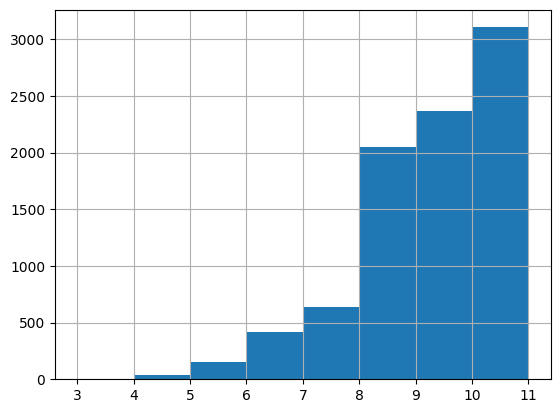

In [23]:
plt.hist(conteo, bins=len(np.unique(conteo))- 1)
plt.grid()
plt.show()

Se necesita que las estaciones tengas la misma cantidad y los mismo registros de fecha

In [40]:
top_fechas = fechas[np.where(conteo >= 9)]

In [41]:
df_cln = df_col[df_col["datetime"].isin(top_fechas)].copy()

In [42]:
df_col.shape , df_cln.shape

((77664, 16), (53425, 16))

In [43]:
df_cln = df_cln.sort_values("datetime").reset_index(drop=True)

In [44]:
df_cln["datetime"].diff().value_counts().head()

datetime
0 days 00:00:00    47955
0 days 01:00:00     5306
0 days 02:00:00       41
0 days 17:00:00       17
0 days 16:00:00       16
Name: count, dtype: int64